# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `Aug 2023`.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="hedge_fund_series",index_col = 0)
df.index.name = 'date'
df.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027034,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022143
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025242
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028607,-0.007963
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818


In [3]:
merrill = pd.read_excel("proshares_analysis_data.xlsx",sheet_name = 'merrill_factors', index_col = 0)
merrill.index.name = 'date'
merrill.head()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,
2011-08-31,-0.054975,0.000009,-0.092548,-0.087549,-0.005889,-0.088915
2011-09-30,-0.069421,0.000017,-0.179066,-0.108081,0.142180,-0.111504
2011-10-31,0.109147,-0.000013,0.162987,0.096274,-0.069502,0.151010
2011-11-30,-0.004063,0.000000,-0.019722,-0.021764,0.054627,-0.003783
2011-12-31,0.010449,0.000009,-0.042649,-0.021747,0.075581,0.005143


## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [4]:
df = df.merge(merrill.loc[:,['SPY US Equity']], left_index = True, right_index = True)

In [5]:
mean_ = df.mean(numeric_only=True)
volatility = df.std(numeric_only=True)
sharpe = mean_ / volatility

mean_annualized = mean_ * 12
volatility_annualized = volatility * (12 ** (1/2))
sharpe_annualized = mean_annualized /volatility_annualized
#dictionary
data = {
    'Mean': mean_annualized,
    'Volatility': volatility_annualized,
    'Sharpe Ratio': sharpe_annualized
}

# Create a dataframe with the dictionary
df_statistics = pd.DataFrame(data)

df_statistics

,Mean,Volatility,Sharpe Ratio
HFRIFWI Index,0.043223,0.060228,0.717668
MLEIFCTR Index,0.031885,0.056966,0.559721
MLEIFCTX Index,0.030399,0.056806,0.535142
HDG US Equity,0.020513,0.059367,0.345534
QAI US Equity,0.019611,0.050062,0.391729
SPY US Equity,0.133240,0.145944,0.912950


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [6]:
df_statistics['Skewness'] = df.skew()
df_statistics['Excess Kurtosis'] = df.kurtosis()
df_statistics['VaR'] = df.quantile(.05, axis = 0, numeric_only = True)
cvars = df.apply(lambda col: col[col <= col.quantile(0.05)].mean())
df_statistics['CVaR'] = cvars

In [7]:
wealth_index = 1000*(1+df).cumprod()
previous_peaks = wealth_index.cummax()
drawdowns = (wealth_index - previous_peaks)/previous_peaks

df_statistics['Max Drawdown'] = drawdowns.min()
df_statistics['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
df_statistics['Bottom'] = drawdowns.idxmin()
    
recovery_date = []
for col in wealth_index.columns:
    prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
    recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
    recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())


In [8]:
df_statistics

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR,CVaR,Max Drawdown,Peak,Bottom
HFRIFWI Index,0.043223,0.060228,0.717668,-0.983171,5.918307,-0.025130,-0.037478,-0.115473,2019-12-31,2020-03-31
MLEIFCTR Index,0.031885,0.056966,0.559721,-0.255827,1.664342,-0.028656,-0.035857,-0.124302,2021-06-30,2022-09-30
MLEIFCTX Index,0.030399,0.056806,0.535142,-0.241814,1.631565,-0.028927,-0.035816,-0.124388,2021-06-30,2022-09-30
HDG US Equity,0.020513,0.059367,0.345534,-0.243959,1.780069,-0.031158,-0.037576,-0.140721,2021-06-30,2022-09-30
QAI US Equity,0.019611,0.050062,0.391729,-0.458360,1.737586,-0.020086,-0.032696,-0.137716,2021-06-30,2022-09-30
SPY US Equity,0.133240,0.145944,0.912950,-0.411185,0.788528,-0.068038,-0.086661,-0.239271,2021-12-31,2022-09-30


In [9]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [10]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6)
        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret.values-rf.values).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error)

In [11]:
hedge_funds = df.columns
factor = merrill['SPY US Equity']
rf = merrill['USGG3M Index']

df_lst= []
for fund in hedge_funds:
    fund_ret = df[fund]
    reg = regression_based_performance(factor,fund_ret,rf)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [fund]))

reg_performance = pd.concat(df_lst)
reg_performance

,Market Beta,Treynor Ratio,Information Ratio,Alpha,R-Squared
HFRIFWI Index,0.348706,0.097045,-0.100529,-0.000270,0.714001
MLEIFCTR Index,0.349620,0.064360,-0.580287,-0.001225,0.802298
MLEIFCTX Index,0.348325,0.060334,-0.631588,-0.001334,0.800846
HDG US Equity,0.359366,0.030971,-0.983914,-0.002281,0.780469
QAI US Equity,0.296053,0.034546,-0.784446,-0.001653,0.744890
SPY US Equity,1.000000,0.123856,-0.338326,-0.000000,1.000000


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

1) The differences between SPY and the hedge-fund series?

SPY has a higher mean, volatility, and Sharpe Ratio than that of all hedge-fund series. Also, the SPY has smaller tail risks in terms of VaR, and CVaR. Besides, all hedge-fund series have a negative information ratio, which indicates that they fail to beat the market.


In [12]:
df_statistics

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR,CVaR,Max Drawdown,Peak,Bottom
HFRIFWI Index,0.043223,0.060228,0.717668,-0.983171,5.918307,-0.025130,-0.037478,-0.115473,2019-12-31,2020-03-31
MLEIFCTR Index,0.031885,0.056966,0.559721,-0.255827,1.664342,-0.028656,-0.035857,-0.124302,2021-06-30,2022-09-30
MLEIFCTX Index,0.030399,0.056806,0.535142,-0.241814,1.631565,-0.028927,-0.035816,-0.124388,2021-06-30,2022-09-30
HDG US Equity,0.020513,0.059367,0.345534,-0.243959,1.780069,-0.031158,-0.037576,-0.140721,2021-06-30,2022-09-30
QAI US Equity,0.019611,0.050062,0.391729,-0.458360,1.737586,-0.020086,-0.032696,-0.137716,2021-06-30,2022-09-30
SPY US Equity,0.133240,0.145944,0.912950,-0.411185,0.788528,-0.068038,-0.086661,-0.239271,2021-12-31,2022-09-30


2) Which performs better between HDG and QAI? 

    According to the Market Beta, QAI is better because it has a lower exposure to the market (systematic risk component). Then it has a better Treynor Ratio (has a better risk-reward tradeoff).
    
    Additionally, QAI has a higher alpha (less negative) and also a better information ratio(the Sharpe Ratio of the non-factor component of the return).
    
    Then QAI performs better, since it has lower volatility and better risk adjusted returns.

3. Whether HDG and the ML series capture the most notable properties of HFRI

    Both HDG and the ML series fail to deliver the same high returns compensated with the high risk of HRFI. The HFRI also shows a very high excess kurtosis, but all of the hedge-fund series has a very small excess kurtosis.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

In [13]:
asset_corr = df.corr()

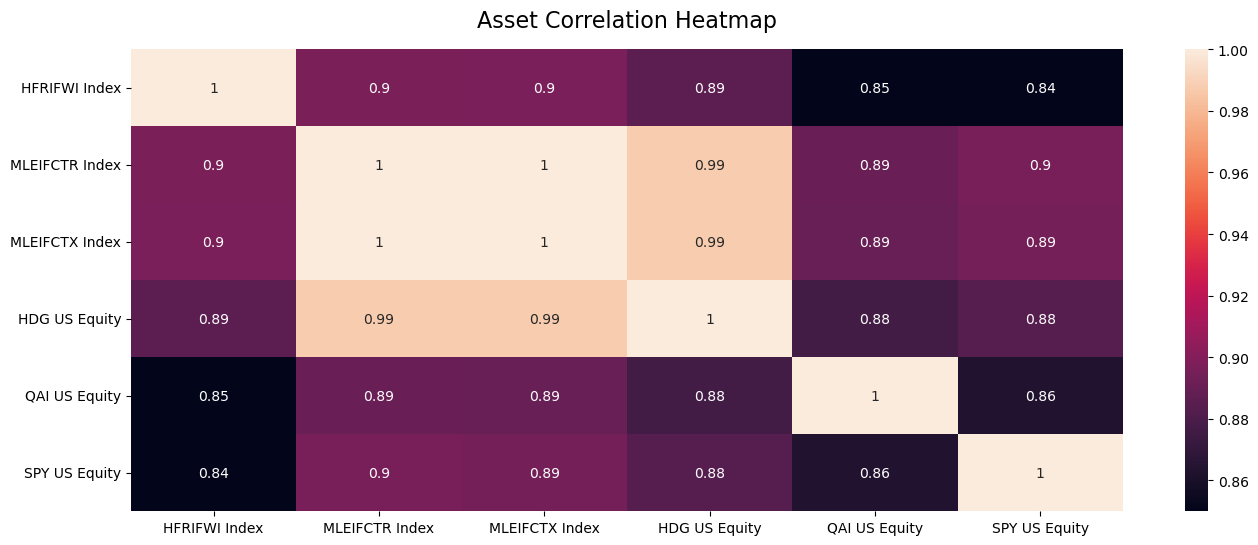

In [14]:
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(asset_corr, vmin=0.85, vmax=1, annot=True)
heatmap.set_title('Asset Correlation Heatmap', fontdict={'fontsize':16}, pad=16);

In [17]:
sorted_corr.nlargest(3,'Correlations')

,,Correlations
MLEIFCTX Index,MLEIFCTR Index,0.999921
MLEIFCTR Index,MLEIFCTX Index,0.999921
HDG US Equity,MLEIFCTR Index,0.987349


In [19]:
sorted_corr.nsmallest(1, 'Correlations')

,,Correlations
HFRIFWI Index,SPY US Equity,0.844986


## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

#### a. Report the intercept and betas.
#### b. Are the betas realistic position sizes, or do they require huge long-short positions?
#### c. Report the R-squared.
#### d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [20]:
hedge_funds = df.columns
factor = merrill
rf = merrill['USGG3M Index']

df1_lst= []
pred = []
for fund in hedge_funds:
    fund_ret = df[fund]
    reg = regression_based_performance(factor,fund_ret,rf)
    beta = dict(reg[0])
    beta.update(Intercept = float(reg[3]))
    beta.update(RSquared = float(reg[4]))
    beta.update(TrackingError = float(reg[5]))
    df1_lst.append(pd.DataFrame([beta],index = [fund]))
    
    
    one_df = pd.DataFrame(np.ones(fund_ret.shape[0])).T
    one_df.columns = factor.index
    factor_ret = pd.concat([factor.T,one_df])
    reg_param = pd.DataFrame([beta]).loc[:,['SPY US Equity','USGG3M Index','EEM US Equity','EFA US Equity','EUO US Equity','IWM US Equity','Intercept']]
    pred.append(pd.DataFrame(np.array(reg_param) @ np.array(factor_ret),columns = factor.index, index = [fund]))
    
    
hedge_replication = pd.concat(df1_lst)
hedge_replication.loc[['HFRIFWI Index']]

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,Intercept,RSquared,TrackingError
HFRIFWI Index,0.033308,-0.165908,0.077857,0.08241,0.022649,0.152074,0.001383,0.836901,0.024323


The betas look like realistic position sizes. They do not require huge long-short positions. 

The RSquared is high (0.837), so could indicates a good performance of the model.


#### Performance Stats of Predicted Returns from Above Regression

In [22]:
hedge_replication_pred = pd.concat(pred)
hedge_replication_performance = performance_summary(hedge_replication_pred.T)
hedge_replication_performance

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.043226,0.055098,0.784533,-0.464616,1.782249,-0.024698,-0.033144,-0.091189,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,0.031882,0.055197,0.577596,-0.454243,1.752550,-0.026529,-0.034314,-0.094043,2019-12-31,2020-03-31,2020-11-30
MLEIFCTX Index,0.030396,0.055025,0.552408,-0.453480,1.745600,-0.026494,-0.034330,-0.094010,2019-12-31,2020-03-31,2020-11-30
HDG US Equity,0.020516,0.056703,0.361809,-0.451992,1.752731,-0.028367,-0.036203,-0.104748,2021-06-30,2022-09-30,NaT
QAI US Equity,0.019605,0.045539,0.430511,-0.382793,1.040575,-0.022931,-0.028758,-0.086634,2021-08-31,2022-09-30,2023-07-31
SPY US Equity,0.133240,0.145944,0.912950,-0.411185,0.788528,-0.068038,-0.086661,-0.239271,2021-12-31,2022-09-30,NaT


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [25]:
def rolling_regression_param(factor,fund_ret,roll_window = 60):
    """ 
        Returns the Rolling Regression parameters for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            roll_window = rolling window for regression
        Output:
            params - Dataframe with time-t as the index and constant and Betas as columns
    """
    X = sm.add_constant(factor)
    y= fund_ret
    rols = RollingOLS(y, X, window=roll_window)
    rres = rols.fit()
    params = rres.params.copy()
    params.index = np.arange(1, params.shape[0] + 1)
    return params
    

In [26]:
df2_lst= []
for fund in hedge_funds:
    fund_ret = pd.DataFrame(df[fund].copy())
    rolling_reg = rolling_regression_param(merrill,fund_ret)
    factor_ret = merrill.iloc[rolling_reg.dropna().index.min():]
    one_df = pd.DataFrame(np.ones(factor_ret.shape[0])).T
    one_df.columns = factor_ret.index
    factor_ret = pd.concat([one_df,pd.DataFrame(factor_ret).T])
    df2_lst.append(pd.DataFrame(np.diag(pd.DataFrame(np.array(rolling_reg[59:]) @ np.array(factor_ret))), index = factor_ret.columns, columns = [fund]).T)
    
    
rolling_reg_replication = pd.concat(df2_lst)
rolling_reg_replication.T

rolling_reg_performance = performance_summary(rolling_reg_replication.T)
rolling_reg_performance.loc[['HFRIFWI Index']]

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.038576,0.060259,0.640166,-0.461504,1.246957,-0.02723,-0.036061,-0.097451,2021-12-31,2022-09-30,NaT


In [28]:
actual_performance = performance_summary(df[59:])
actual_performance.loc[['HFRIFWI Index']]

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.05597,0.066759,0.838382,-1.132664,6.706593,-0.023775,-0.040163,-0.115473,2019-12-31,2020-03-31,2020-08-31


The rolling estimate has a lower mean than the actual return. The variance is also lower, but not as much as the mean, so the Sharpe Ratio. Overall it is a good model, according to the graph below, it captures almost entirely the behavior of the series, except at some extreme points.

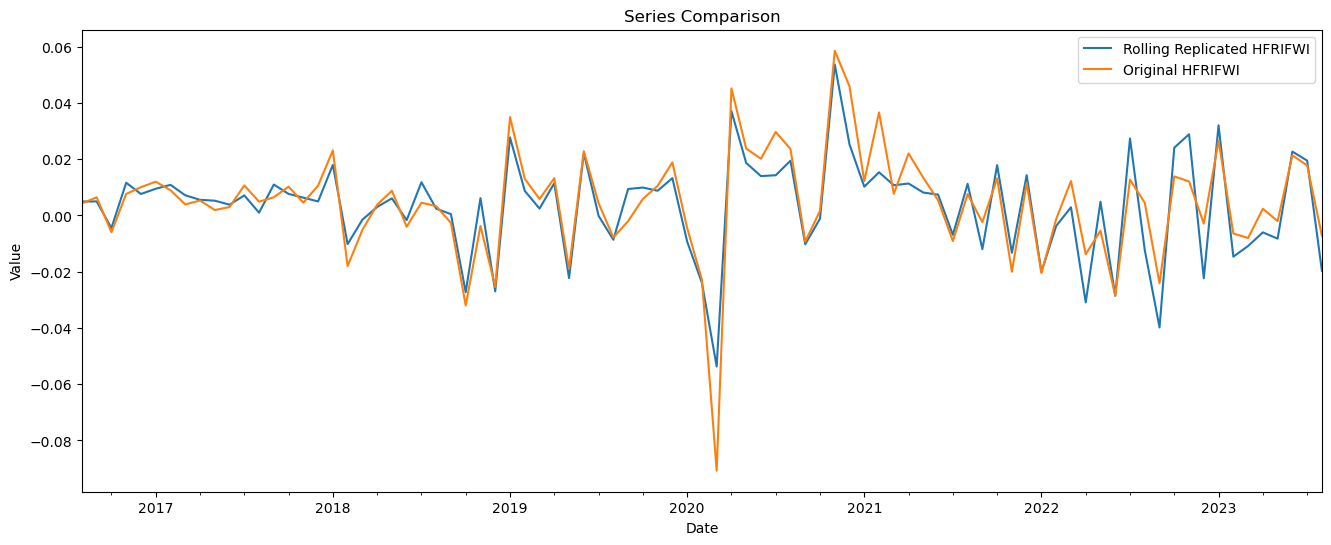

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

ax = rolling_reg_replication.T['HFRIFWI Index'].plot(label='Rolling Replicated HFRIFWI')
df.iloc[rolling_reg.dropna().index.min():]['HFRIFWI Index'].plot(ax=ax, label='Original HFRIFWI')

plt.xlabel('Date')

plt.ylabel('Value')

plt.title('Series Comparison')

plt.legend()

plt.show()


## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [35]:
hedge_funds = df.columns
factor = merrill
rf = merrill['USGG3M Index']

df3_lst= []
for fund in hedge_funds:
    fund_ret = df[fund]
    reg = regression_based_performance(factor,fund_ret,rf,constant=False)
    beta = dict(reg[0])
    beta.update(RSquared = float(reg[2]))
    beta.update(TrackingError = float(reg[3]))
    df3_lst.append(pd.DataFrame([beta],index = [fund]))
    
    
no_constant_replication = pd.concat(df3_lst)
no_constant_replication.loc[['HFRIFWI Index']]

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,RSquared,TrackingError
HFRIFWI Index,0.050858,0.337787,0.077639,0.075253,0.025636,0.148556,0.839926,0.024436


In [36]:
hedge_replication.loc[['HFRIFWI Index']]

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,Intercept,RSquared,TrackingError
HFRIFWI Index,0.033308,-0.165908,0.077857,0.08241,0.022649,0.152074,0.001383,0.836901,0.024323


The R-squared is very similar in both models and the betas of all factors except USGG3M remain more or less similar. For USGG3M, the beta no longer indicates a short position, but a more or less large long position.

In [40]:
merrill_summary = performance_summary(merrill)
df4_lst = []
for fund in df.columns:
    fit_ret = np.array(no_constant_replication[no_constant_replication.index == fund][merrill.columns]) @ np.array(merrill.T)

    df4_lst.append(pd.DataFrame(fit_ret.T,columns = [fund], index = [merrill.index] ).T)

fit_returns = pd.concat(df4_lst)
mean_fit_returns = performance_summary(fit_returns.T).rename(columns = {'Mean':'Mean Fitted Returns'})
mean_fit_returns = mean_fit_returns.loc[:,['Mean Fitted Returns']].merge(df_statistics.loc[:,['Mean']], on = mean_fit_returns.index).rename(columns={'key_0' : 'Hedge Fund','Mean':'Mean Actual Returns'}).set_index('Hedge Fund')
mean_fit_returns.loc[['HFRIFWI Index']]

,Mean Fitted Returns,Mean Actual Returns
Hedge Fund,,
HFRIFWI Index,0.033082,0.043223


In [43]:
no_constant_replication = np.corrcoef(df['HFRIFWI Index'], fit_returns.T['HFRIFWI Index'])[0,1]
constant_replication = np.corrcoef(df['HFRIFWI Index'], hedge_replication_pred.T['HFRIFWI Index'])[0,1]
pd.DataFrame([[no_constant_replication,constant_replication]],columns=['Without Intercept','With Intercept'],index = ['Fitted & Actual Return Correlation'])


,Without Intercept,With Intercept
Fitted & Actual Return Correlation,0.914034,0.914823


Recall that if our porfolio is trying to deliver hedge-fund returns (including their mean and high SR) via an ETF, then the replication should definitely not include an intercept in the regression. It should make the replication factors match the mean, so that the investors in the ETF match the mean, not just the variation of HFRI. 

However, if our porfolio is only trying to deliver a hedge, or a similar variation, then we should include an intercept, and accept that the replication will differ in mean returns by alpha but will match variation anyway. 

Since the HDG's actual mean returns are lower than HFRI Index, we believe that Proshares and Merrill Lynch are running the regression without an intercept. This is also due to the fact that dropping the intercept forces the least square algorithm to use the factors to fit the means returns of the fund, thereby giving an optimized portfolio where the beta coefficients are interpreted as the factor weights in the clone for each respective fund